In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ls

In [2]:
# %cd gdrive/My\ Drive/nlp/
# !ls

In [3]:
# %pip install nltk wordcloud
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import nltk
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score
from scipy.sparse import hstack
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ilya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df_train = pd.read_csv('train.csv').fillna(' ')
df_test = pd.read_csv('test.csv').fillna(' ')

df_train.keyword = df_train.keyword.str.replace("%20", " ")
df_test.keyword = df_test.keyword.str.replace("%20", " ")


# Data preprocessing

In [6]:
df_train.text = df_train.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_test.text = df_test.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_train.text = df_train.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_test.text = df_test.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [7]:
def preprocess_news(df):
    stops = set(stopwords.words('english'))
    new_corpus=[]

    lem=WordNetLemmatizer()
    for text in df["text"]:
        words=[w for w in word_tokenize(text) if (w not in stops)]

        words=[lem.lemmatize(w) for w in words]

        new_corpus += words
    return set(new_corpus)

In [8]:
corpus = preprocess_news(df_train)

In [9]:
corpus #Unique words

{'attendance',
 'ColleenMNelson',
 'Leicester',
 'deluded',
 'Kit',
 'batting',
 'flamethrower',
 'faved',
 'truth',
 'Internally',
 'BLIGHT',
 'Miville',
 'TECHNIQUE',
 'Bans',
 'BIOTERRORISMI',
 'Sr',
 'TIX',
 'contribute',
 'stare',
 'windstorm',
 'swell',
 'summerinsweden',
 'lightbulb',
 'Dawson',
 'Spurs',
 'slaughter',
 'WNW',
 'third',
 'CHPSRE',
 'REALLY',
 'Florence',
 'Sat',
 'alrasyid448ItuRasya',
 'pressed',
 'Philippine',
 'M27329',
 'DAMN',
 'engineerd',
 'Marine',
 'DUH',
 'Poisoned',
 'DEANS',
 'blowout',
 'salem',
 'Youth',
 'precedent',
 'entire',
 'Hint',
 '143',
 'Bridgeport',
 'Liar',
 'swollen',
 'merged',
 'Better',
 'angry',
 '1145',
 'Gods',
 'Counselors',
 'ZiUW',
 'Shore',
 'stump',
 'Donnie',
 'Judicial',
 'EP18',
 'live',
 'toke',
 'surf',
 'Liquidation',
 'ColoradoAvalanche',
 'Kills',
 'MalaysiaAirlines',
 'touchdown',
 'Geneva',
 'Start',
 '319',
 'Shoppe',
 'Ibeto',
 '65',
 'presume',
 'Agency',
 'Edward',
 'skiing',
 'Sites',
 'idea',
 'Into',
 'persi

In [10]:
def preprocess(text):
    stops = set(stopwords.words('english'))

    lem=WordNetLemmatizer()

    words=[w for w in word_tokenize(text) if (w not in stops)]

    words=[lem.lemmatize(w) for w in words]
   
    return words

In [11]:
df_train.text = df_train.text.apply(lambda x: ' '.join(preprocess(x)))
df_test.text = df_test.text.apply(lambda x: ' '.join(preprocess(x)))

В ходе подготовки данных каждое предложение было разбито на слова, произведено избавление от стоп-слов, лемматизация слов

# EDA

## Target and not target records count

0    4342
1    3271
Name: target, dtype: int64


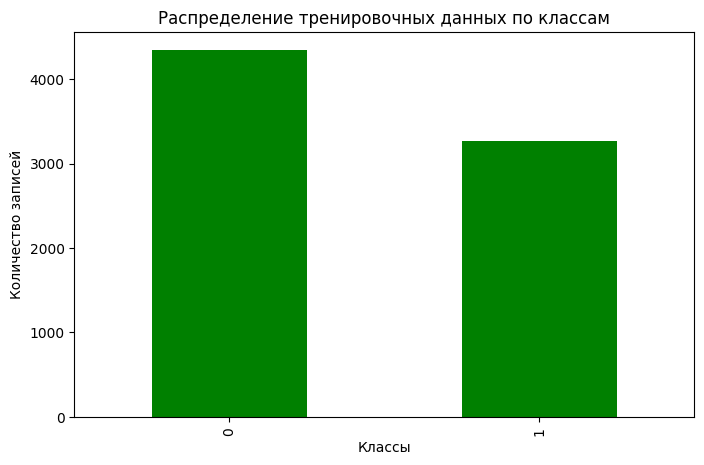

In [12]:
plt.figure(figsize=(8,5))
df_train['target'].value_counts().plot(kind='bar',color='green')
plt.title('Распределение тренировочных данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')
print(df_train['target'].value_counts())

## Keywords statistics

<AxesSubplot:title={'center':'Распределение ключевых слов в тренировочных данных'}, xlabel='Количество', ylabel='Ключевые слова'>

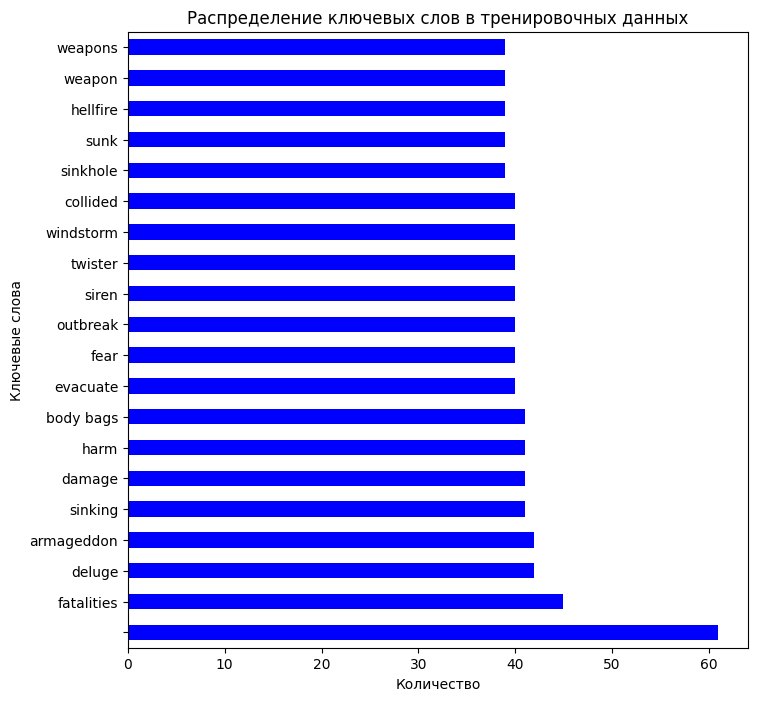

In [13]:
plt.figure(figsize=(8,8))
plt.title('Распределение ключевых слов в тренировочных данных')
plt.xlabel('Количество')
plt.ylabel('Ключевые слова')
df_train['keyword'].value_counts()[:20].plot(kind='barh',color='blue')

## Locations statistics

<AxesSubplot:title={'center':'Распределение по геолокации'}, xlabel='Количество', ylabel='Основные точки геолокации'>

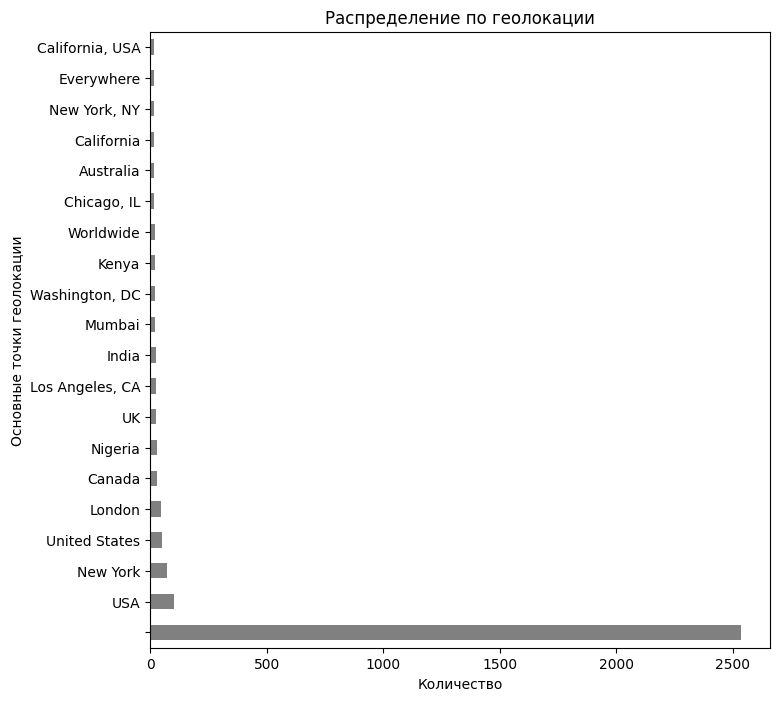

In [14]:
plt.figure(figsize=(8,8))
plt.title('Распределение по геолокации')
plt.xlabel('Количество')
plt.ylabel('Основные точки геолокации')
df_train['location'].value_counts()[:20].plot(kind='barh',color='grey')

По графику можно понять географию распределения твитов. Как мы видим из графика, наибольшее количество твитов были созданы без указанного местоположения

## Disaster and Non Disaster tweets length

Text(0, 0.5, 'Количество твитов')

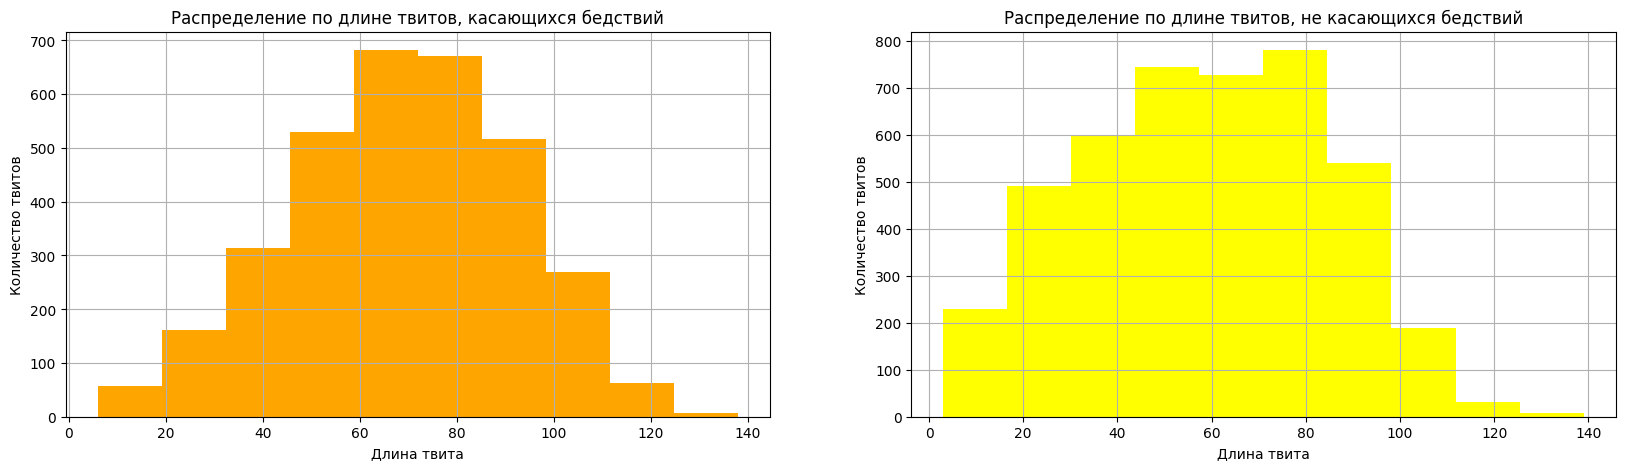

In [15]:
tweet_dis = df_train[df_train['target']==1]
tweet_ndis = df_train[df_train['target']==0]
len_dis = tweet_dis.text.str.len()
len_ndis = tweet_ndis.text.str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_dis,color='orange')
plt.grid()
plt.title('Распределение по длине твитов, касающихся бедствий')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')
plt.subplot(1,2,2)
plt.hist(len_ndis,color='yellow',)
plt.grid()
plt.title('Распределение по длине твитов, не касающихся бедствий')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

## Disaster and Non Disaster word length

Text(0, 0.5, 'Количество слов')

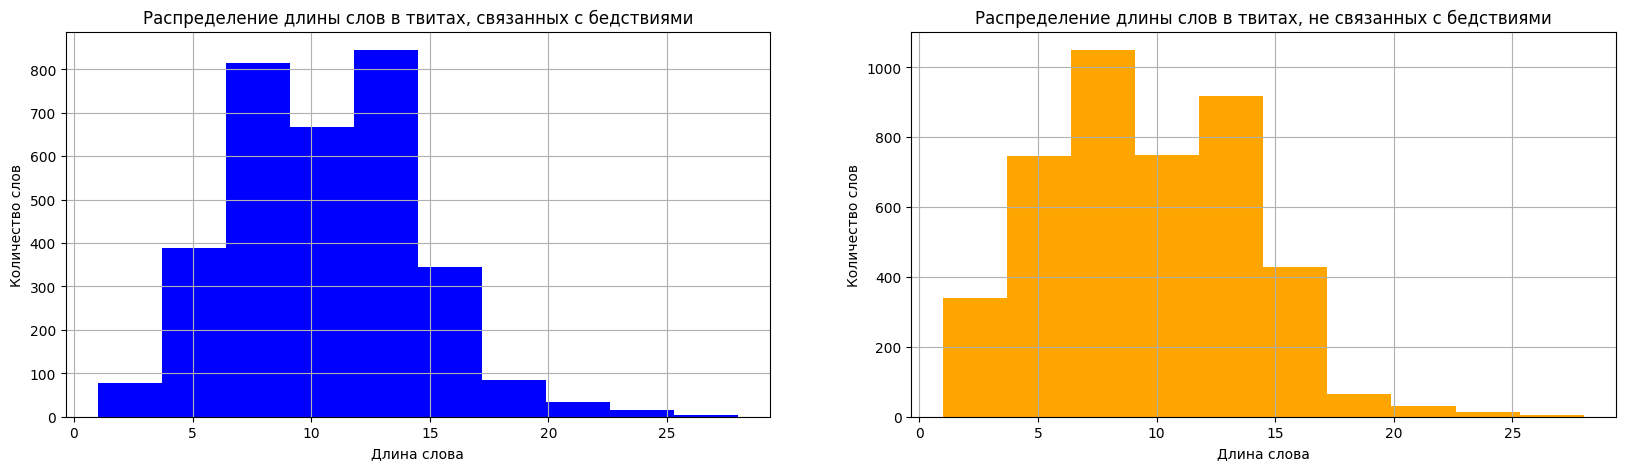

In [16]:
words_dis = df_train[df_train['target']==1]['text'].str.split().map(lambda x:len(x))
words_ndis = df_train[df_train['target']==0]['text'].str.split().map(lambda x:len(x))
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(words_dis,color='blue')
plt.grid()
plt.title('Распределение длины слов в твитах, связанных с бедствиями')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')
plt.subplot(1,2,2)
plt.hist(words_ndis,color='orange',)
plt.grid()
plt.title('Распределение длины слов в твитах, не связанных с бедствиями')
plt.xlabel('Длина слова')
plt.ylabel('Количество слов')

В ходе составления графиков EDA были проанализированы такие колонки DataFrame, как распределение по геолокации, ключевым словам, является ли данный твит действительно сигналом о бедствии, также проанализированы длина предложений и слов в твитах. По анализу графика ключевых слов можно сделать вывод о наиболее часто встречающихся ключевых словах в твитах о бедствиях

# Cloud of words

Облако слов представляет собой изображение составленное на основе текста. Воспользовавшись сервисом Word's Cloud мы получили картинку, составленную из ключевых слов, местоположений и слов в тексте. Слова в облаке разного размера и цвета. Размер и цвет зависят от частоты появления данного слова в тексте.

## Keywords

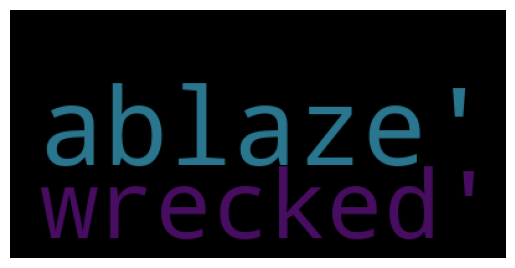

In [17]:
text = df_train.query('keyword!=" "').keyword.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Locations

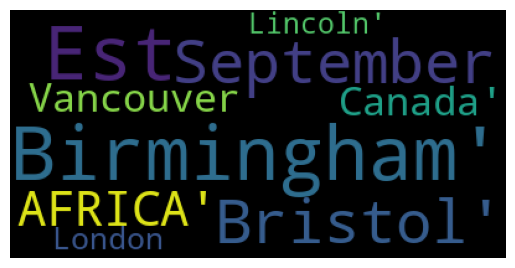

In [18]:
text = df_train.query('location!=" "').location.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Text

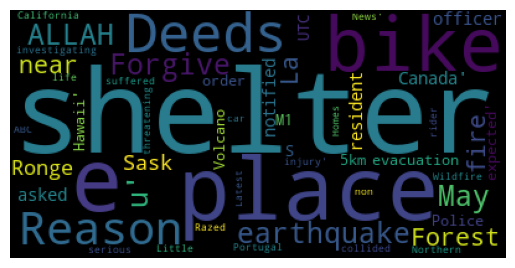

In [19]:
text = df_train.text.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# sklearn.CountVectorize

## Graphics

In [20]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train["text"])
features = count_vectorizer.get_feature_names_out()

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df = train_vectors_df.rename(columns={i: features[i] for i in range(len(features))})
train_vectors_df

,00,000,0000,00end,00pm,01,02,0215,02pm,03,...,zone,zonewolf123,zoom,zotar,zouma,zrnf,zss,zumiez,zurich,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Частота')

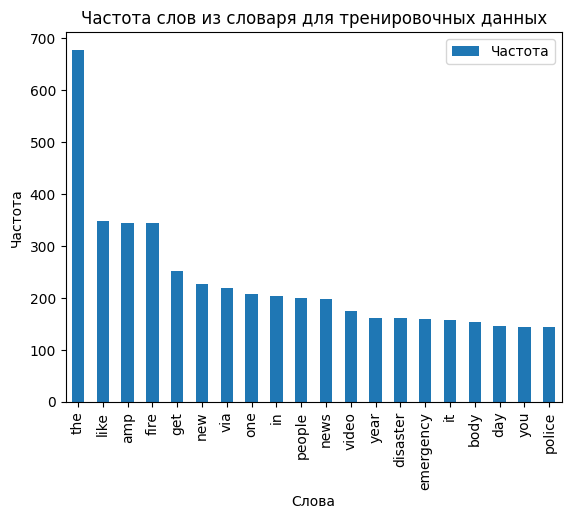

In [21]:
pd.DataFrame(train_vectors.sum(axis=0).T,
             index=count_vectorizer.get_feature_names_out(),
             columns=['Частота']).sort_values(by='Частота',
                                           ascending=False).head(20) \
             .plot(kind='bar',title="Частота слов из словаря для тренировочных данных")
plt.xlabel('Слова')
plt.ylabel('Частота')

График демонстрирует распределение частоты слов в предложениях в тренировочных данных на основе построенной матрицы с помощью CountVectorizer

In [22]:
test_vectors = count_vectorizer.transform(df_test["text"])
features = count_vectorizer.get_feature_names_out()
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df = test_vectors_df.rename(columns={i: features[i] for i in range(len(features))})
test_vectors_df

,00,000,0000,00end,00pm,01,02,0215,02pm,03,...,zone,zonewolf123,zoom,zotar,zouma,zrnf,zss,zumiez,zurich,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Частота')

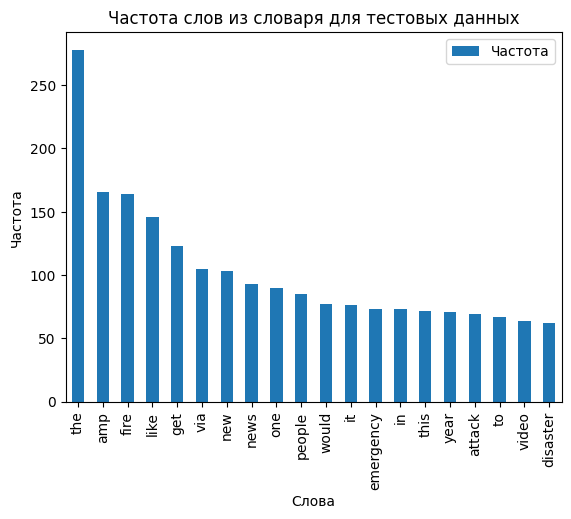

In [23]:
pd.DataFrame(test_vectors_df.sum(axis=0).T,
             index=count_vectorizer.get_feature_names_out(),
             columns=['Частота']).sort_values(by='Частота',
                                           ascending=False).head(20) \
             .plot(kind='bar',title="Частота слов из словаря для тестовых данных")
plt.xlabel('Слова')
plt.ylabel('Частота')

График демонстрирует распределение частоты слов в предложениях в тестовых данных на основе построенной матрицы с помощью CountVectorizer

## PCA

In [24]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb

In [25]:
def plot_LSA(test_data, test_labels, savepath="PCA_data.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

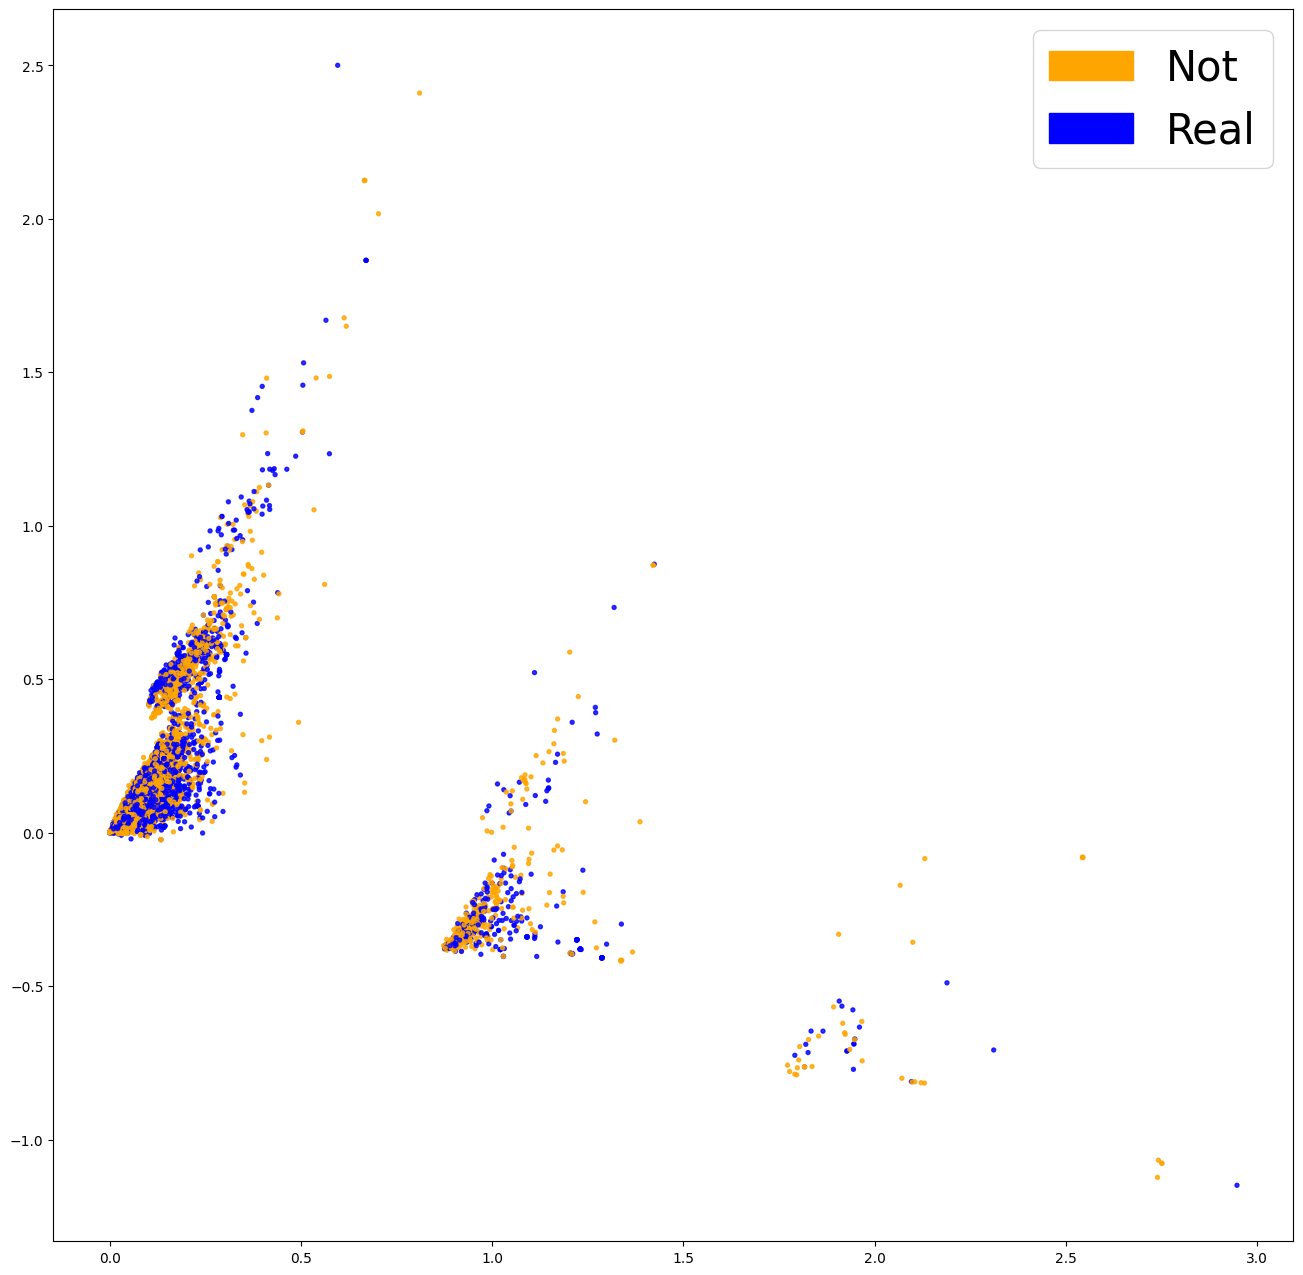

In [26]:
train_counts = cv(df_train.text)
train_labels = df_train.target.values
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train_counts, train_labels)
plt.show()

График, отображающий схожесть векторов и выражений

# TF-IDF

Подход чем то похож на CountVectorize, только здесь для каждого токена используется метрика
TF-IDF. 

- Частота слова (Term Frequency) — подсчитывает, как часто выбранное слово появляется в документе.

- Обратная частота документа (Inverse Document Frequency) — снижает вес слов, которые часто встречаются в документах.

In [27]:
train_text = df_train['text']
test_text = df_test['text']
summary_text = pd.concat([train_text, test_text])

In [28]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(summary_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [29]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(summary_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [30]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [31]:
train_features.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11683182, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [32]:
train_oof = np.zeros(df_train.shape[0],)
kf = KFold(n_splits=5, random_state=137, shuffle=True)
test_preds = 0

for jj, (train_index, val_index) in enumerate(kf.split(train_features)):
        print("Fitting fold", jj+1)
        train_x = train_features.toarray()[train_index]
        val_x = train_features.toarray()[val_index]
        train_target = df_train['target'].values[train_index]
        classifier = LogisticRegression(solver='sag')
        classifier.fit(train_x, train_target)
        train_oof[val_index] = classifier.predict_proba(val_x)[:,1]
        test_preds += classifier.predict_proba(test_features)[:,1]/5
        
print(roc_auc_score(df_train['target'].values, train_oof))

Fitting fold 1
Fitting fold 2
Fitting fold 3
Fitting fold 4
Fitting fold 5
0.867532132311348


In [33]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [34]:
submission['target'] = 1*(test_preds > 0.5)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Metrics

In [35]:
print("RECALL:", recall_score(y_true=df_train['target'],
                              y_pred=pd.Series(1*(train_oof > 0.5))),
      )
print("ROC_AUC:", roc_auc_score(df_train['target'].values, train_oof))

RECALL: 0.6961173952919596
ROC_AUC: 0.867532132311348


Для данной задачи наиболее интересны метрики Recall и Roc Auc Score. Ведь нам важно определить 
как можно больше бедствий из твитов, и не так страшно, если какой то твит будет опознан ложно положительно.
Ведь страшнее не узнать о катастрофе, чем получить ложную тревогу.

Вот наши результаты по метрикам:
*RECALL:* 0.6961173952919596
*ROC_AUC:* 0.8675331884498999